<a href="https://www.kaggle.com/code/franciscomesquita/yolov5-football-ball-detection?scriptVersionId=103957288" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# YOLOv5 ball detection
### References

* YOLOv5 repository - https://github.com/ultralytics/yolov5
* https://www.kaggle.com/code/eneszvo/yolov5-helmet-detection-train-and-inference
* https://medium.com/@gonzacor/ball-tracking-and-detection-in-sports-with-new-yolov5-9f30f5252cf2

MoviePy is a Python module for video editing, which can be used for basic operations (like cuts, concatenations, title insertions), video compositing (a.k.a. non-linear editing), video processing, or to create advanced effects. It can read and write the most common video formats, including GIF.

Here it will be used to play the video at the end with the respective ball detection applied

- https://zulko.github.io/moviepy/

In [1]:
!pip install moviepy -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2021.6.0 requires fsspec==2021.06.0, but you have fsspec 2021.6.1 which is incompatible.


In [2]:
# Creating a tmp folder and get inside it. It will be used to put model weights and the video sample

%cd ../
!mkdir tmp
%cd tmp

/kaggle
/kaggle/tmp


In [3]:
# Download YOLOv5

!git clone https://github.com/ultralytics/yolov5  # clone repo

%cd yolov5

# Install dependencies
%pip install -qr requirements.txt  # install all dependencies

%cd ../

import torch
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 11966, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11966 (delta 5), reused 6 (delta 3), pack-reused 11953
Receiving objects: 100% (11966/11966), 12.41 MiB | 19.32 MiB/s, done.
Resolving deltas: 100% (8227/8227), done.
/kaggle/tmp/yolov5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-cloud 0.1.13 requires tensorflow<3.0,>=1.15.0, which is not installed.
Note: you may need to restart the kernel to use updated packages.
/kaggle/tmp
Setup complete. Using torch 1.7.0 (Tesla P100-PCIE-16GB)


In [4]:
#All imports necessary

import os
import gc
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from shutil import copyfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import subprocess

In [5]:
#Copy files that wil be used to the tmp/yolov5/ folder

%cd ../
!cp -r input/dfl-yolov5l6-ball-detection/yolov5l6_trained_600images.pt tmp/yolov5/
!cp -r input/testsample/testSample.mp4 tmp/yolov5/
%cd tmp/yolov5/

/kaggle
/kaggle/tmp/yolov5


# YOLOv5 Inference with the video sample

YOLOv5 pré-trained with 600 ball images. Due to its architecture, the concept "You only look Once" is applied. This approach uses a single neural network to process the entire picture, then separates it into parts and predicts bounding boxes and probabilities for each component. These bounding boxes are weighted by the expected probability. The method “just looks once” at the image in the sense that it makes predictions after only one forward propagation run through the neural network. It then delivers detected items after non-max suppression (which ensures that the object detection algorithm only identifies each object once).

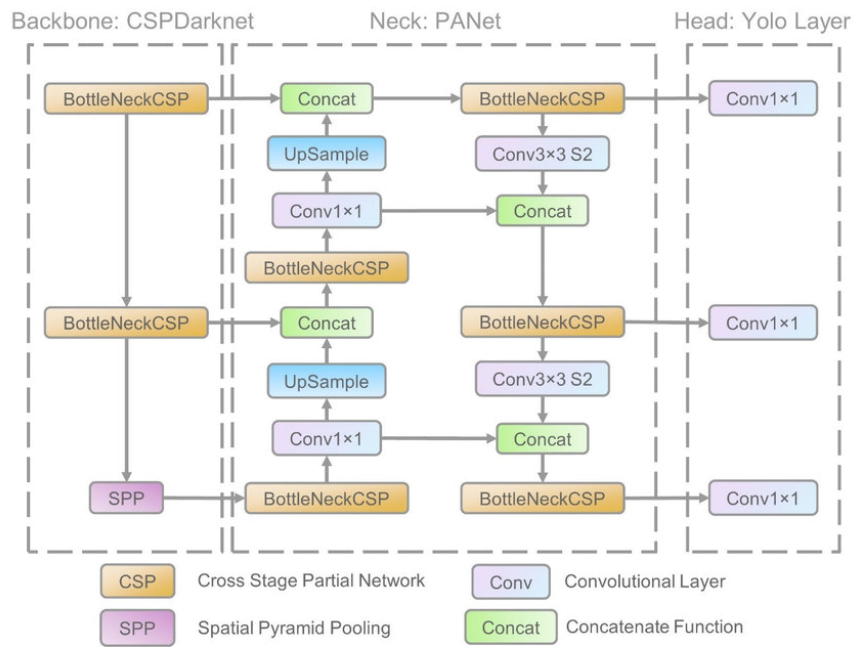

In [6]:
#img: resolution
#weights: weights learned in the already pre-trained model
#source: sample where the model will be applied

!python detect.py --img 1280 \
                  --weights yolov5l6_trained_600images.pt \
                  --source testSample.mp4 \
                  --project DFL

detect: weights=['yolov5l6_trained_600images.pt'], source=testSample.mp4, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=DFL, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.2-47-geab35f6 Python-3.7.10 torch-1.7.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 476 layers, 76118664 parameters, 0 gradients, 109.9 GFLOPs
video 1/1 (1/751) /kaggle/tmp/yolov5/testSample.mp4: 768x1280 1 ball, 70.5ms
video 1/1 (2/751) /kaggle/tmp/yolov5/testSample.mp4: 768x1280 1 ball, 65.9ms
video 1/1 (3/751) /kaggle/tmp/yolov5/testSample.mp4: 768x1280 1 ball, 64.6ms
video 1/1 (4/751) /kaggle/tmp/yolov5/testSample.mp4: 768x1280 1 ball, 64.7ms
video 1/1 (5/751) /kaggle/tmp/yolov5/testSample.mp4: 768x1

In [7]:
#Copy result generated by YOLOv5 model to the Kaggle/working folder

!cp -r ./DFL/exp/ /kaggle/working/

In [8]:
#Code necessary to play the video with the detection generated  the model.

import subprocess

#Get video capture (frame by frame)
cap = cv2.VideoCapture("./DFL/exp/testSample.mp4")

frames = []
while True: #While there is images(it will turn into frames) to read
    ret, img = cap.read()
    if ret == False:
        break
    frames.append(img)
    width = img.shape[1]
    height = img.shape[0]
cap.release()

#Build the video with frames created before
video = cv2.VideoWriter("/kaggle/working/tmp.mp4", cv2.VideoWriter_fourcc(*'MP4V'),
                                25, (width,height))
for img in frames:
    video.write(img)

#Compile video
video.release()   

#Play video
subprocess.run(["ffmpeg", "-i", "/kaggle/working/tmp.mp4", "-crf", "18", "-preset", "veryfast",
                "-vcodec","libx264", "/kaggle/working/output.mp4",])

CompletedProcess(args=['ffmpeg', '-i', '/kaggle/working/tmp.mp4', '-crf', '18', '-preset', 'veryfast', '-vcodec', 'libx264', '/kaggle/working/output.mp4'], returncode=0)

# Show result

In [ ]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from IPython.display import Video

filename = "Output.mp4"
ffmpeg_extract_subclip("/kaggle/working/output.mp4", 0, 30, targetname=filename)
    
Video(filename, width=800, embed=True)